In [106]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm

In [107]:
# File
# dir = '../input/riiid-test-answer-prediction/'
dir = './'
FEATURE_FOLDER_PATH = dir + 'riiid_features/'

# Hyper parameters
BATCH_SIZE = 512
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 5e-5

In [108]:

# Read large datasets: https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets
train_dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

# why we removed columns:
#   row_id: redundant
#   task_container_id: tells you what container this question is in
#       the max container size is 5 so not really significant
#   user_answer: doesnt really affect if the answer is correct
#   prior_question_had_explanation: majority of learning (we assume) will be done from lectures, not answer explanations
#

req_cols = ['timestamp', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time',
            'prior_question_had_explanation']

# function to convert the milliseconds to seconds at load time
# messes with the dtypes above and doesn't really save time so it is commented (see converters)
def mil_to_sec(val):
    if val == '':
        return np.NaN
    return round(int(val)/1000)

train_columns = pd.read_csv(dir + 'train.csv', usecols=req_cols, nrows=1).columns
t_index = {col: i for (i, col) in enumerate(train_columns)}
full = pd.read_csv(dir + 'train.csv', usecols=req_cols, dtype=train_dtypes,
                       # converters={'timestamp': mil_to_sec,
                       #             'prior_question_elapsed_time': mil_to_sec},
                       nrows=1000000).sort_values(by='timestamp')
# the following lines are kinda cheating since we don't actually have all the data at once
# train_df = raw_df[raw_df['content_type_id'] == 0]
# lecture_events_df = raw_df[raw_df['content_type_id'] == 1]

questions_df = pd.read_csv(dir + 'questions.csv')
questions_df['tags'] = questions_df['tags'].apply(lambda x: [i for i in str(x).split() if i != 'nan'])
lectures_df = pd.read_csv(dir + 'lectures.csv')
example_test_df = pd.read_csv(dir + 'example_test.csv')

squestions = full[full['content_type_id'] == 0].reset_index()
slectures  = full[full['content_type_id'] == 1].reset_index()

In [109]:
###
### DATA EXPLORATION
###

import matplotlib.pyplot as plt


In [110]:
print('Average Answer Performance: ', squestions['answered_correctly'].mean() * 100)

Average Answer Performance:  65.03576701394664


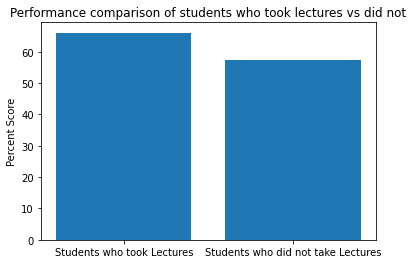

In [111]:
lecture_student_mean = squestions[squestions['user_id'].isin(slectures['user_id'].unique())]['answered_correctly'].mean() * 100
no_lecture_student_mean = squestions[~squestions['user_id'].isin(slectures['user_id'].unique())]['answered_correctly'].mean() * 100

plt.bar(['Students who took Lectures', 'Students who did not take Lectures'],[lecture_student_mean, no_lecture_student_mean])
plt.title('Performance comparison of students who took lectures vs did not')
plt.ylabel('Percent Score')
plt.show()

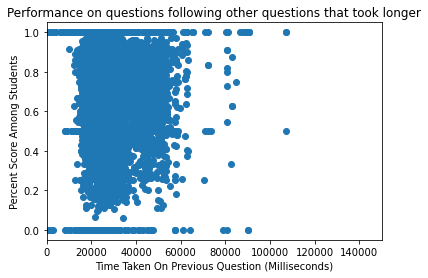

In [112]:
q_time_performance = squestions.groupby('content_id').agg({'answered_correctly': 'mean', 'prior_question_elapsed_time': 'mean'})
plt.scatter(q_time_performance['prior_question_elapsed_time'], q_time_performance['answered_correctly'])
plt.xlim([0,150000])
plt.title('Performance on questions following other questions that took longer')
plt.xlabel('Time Taken On Previous Question (Milliseconds)')
plt.ylabel('Percent Score Among Students')
plt.show()

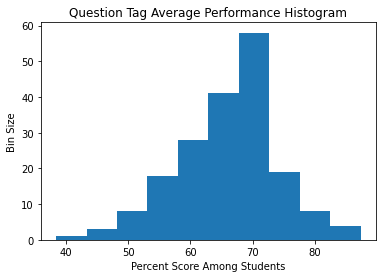

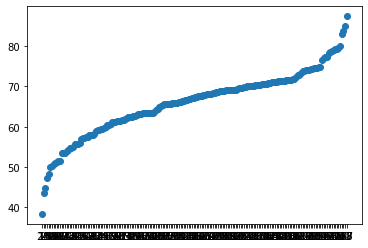

In [113]:
tag_means = questions_df[['question_id', 'tags']].explode('tags') \
    .merge(squestions, left_on='question_id', right_on='content_id').groupby('tags')['answered_correctly'].mean().sort_values() * 100

plt.hist(tag_means, bins=10)
plt.title('Question Tag Average Performance Histogram')
plt.xlabel('Percent Score Among Students')
plt.ylabel('Bin Size')
plt.show()

plt.scatter(tag_means.index, tag_means)

Text(0.5, 1.0, 'Student Relative Timestamp Histogram')

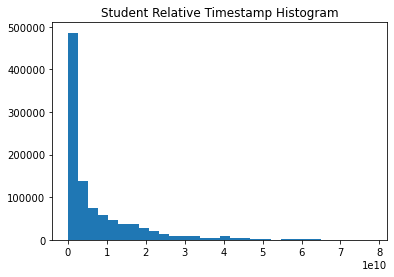

In [114]:
plt.hist(full['timestamp'], bins=30)
plt.title('Student Relative Timestamp Histogram')

Text(0, 0.5, 'Percent Score')

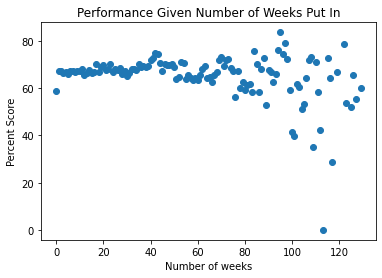

In [125]:
squestions['timestamp_int'] = squestions['timestamp'] // 1000 // 60 // 60 // 24 // 7
grp = squestions.groupby('timestamp_int')['answered_correctly'].mean() * 100
squestions = squestions.drop(columns='timestamp_int')
plt.scatter(grp.index, grp)
plt.title('Performance Given Number of Weeks Put In')
plt.xlabel('Number of weeks')
plt.ylabel('Percent Score')

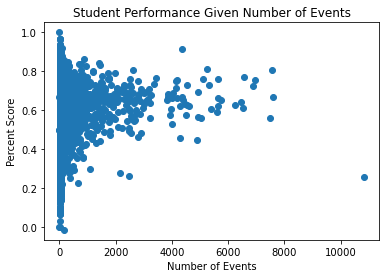

In [138]:
activity_grp = full.groupby(['user_id']).agg({'user_id': 'count', 'answered_correctly': 'mean'})
plt.scatter(activity_grp['user_id'], activity_grp['answered_correctly'])
plt.title('Student Performance Given Number of Events')
plt.xlabel('Number of Events')
plt.ylabel('Percent Score')
plt.show()

In [119]:
grp

timestamp_int
0           0.679491
2           0.000000
3           0.500000
4           0.750000
5           0.500000
              ...   
76809455    1.000000
76809663    0.333333
76809860    0.666667
76810038    0.666667
78091996    0.600000
Name: answered_correctly, Length: 657220, dtype: float64

In [ ]:
# APPLICATION PHASE

In [13]:
def jagged_to_fixed_matrix(x, n , fill_value):
    a = np.full((len(x), n), fill_value)
    for i,xi in enumerate(x):
        a[i][0:min(n,len(xi))] = np.array(xi)[0:min(n, len(xi))]
    return a

def create_batch_iter(n, skip):
    a = list(range(0, n, skip)) + [len(train)]
    return [(a[i], a[i + 1]) for i in range(len(a) - 1)]

In [14]:
class StudentKnowledge:
    def __init__(self, num_tags, max_tags=30, question_avg_default=0.67):
        self.lectures = []
        self.lecture_timestamp = []
        self.questions = []
        self.question_timestamp = []
        self.num_tags = num_tags

        self.question_avg_default = question_avg_default
        self.max_tags = max_tags

    def add_lecture(self, lecture_tag, lecture_timestamp):
        self.lectures.append(lecture_tag)
        self.lecture_timestamp.append(lecture_timestamp)

    def add_question(self, question_answered_right, question_timestamp):
        self.questions.append(question_answered_right)
        self.question_timestamp.append(question_timestamp)

    def get_features(self, row):
        prior_question_elapsed = row[t_index['prior_question_elapsed_time']]
        prior_question_explain = row[t_index['prior_question_had_explanation']]
        # Lecture Tag Indices

        # Additional Features
        num_questions_answered = len(self.questions)
        if num_questions_answered == 0:
            question_avg = self.question_avg_default
        else:
            question_avg = sum(self.questions) / num_questions_answered
        prior_question_elapsed = 0 if str(prior_question_elapsed) == 'nan' else prior_question_elapsed
        prior_question_explain = False if str(prior_question_explain) == '<NA>' else prior_question_explain

        return self.lectures, [question_avg, prior_question_elapsed, prior_question_explain]



class StudentDataset:
    def __init__(self, lectures, questions, train_columns, tags_len=30):
        self.t_index = {col: i for i, col in enumerate(train_columns)}

        self.students = {}
        self.lecture_tags = {row['lecture_id']: row['tag'] for _, row in lectures.iterrows()}
        self.question_tags = {row['question_id']: [int(x) for x in str(row['tags']).split() if x != 'nan'] \
                              for _, row in questions.iterrows()}

        a = questions['tags'].apply(lambda r: [int(x) for x in str(r).split() if x != 'nan']).to_numpy()
        self.num_tags = len(np.unique([x for b in a for x in b]))
        self.tags_len = tags_len

    def read(self, row):
        student_id = row[self.t_index['user_id']]
        content_type_id = row[self.t_index['content_type_id']]
        content_id = row[self.t_index['content_id']]
        timestamp = row[self.t_index['timestamp']]
        answered_right = row[self.t_index['answered_correctly']]

        if student_id not in self.students:
            self.students[student_id] = StudentKnowledge(self.num_tags)
        if content_type_id == 0:
            self.students[student_id].add_question(answered_right, timestamp)
        else:
            self.students[student_id].add_lecture(self.lecture_tags[content_id], timestamp)

    # Must receive question rows, lectures not valid
    def get_features(self, rows):
        for row in rows:
            self.read(row)
        rows = rows[rows[:, t_index['content_type_id']] == 0]
        user_ids = rows[:,self.t_index['user_id']]
        question_ids = rows[:, self.t_index['content_id']]

        question_tags = [self.question_tags[question_id] for question_id in question_ids]
        question_tags = jagged_to_fixed_matrix(question_tags, self.tags_len, self.num_tags)

        student_tags, additional_features = zip(
            *[self.students[user_id].get_features(rows[i]) for i, user_id in enumerate(user_ids)]
        )
        student_tags = jagged_to_fixed_matrix(list(student_tags), self.tags_len, self.num_tags)
        return question_tags, student_tags, list(additional_features), rows[:, t_index['answered_correctly']]

    def reset(self):
        self.students = {}


class Network(nn.Module):
  def __init__(self, num_embeddings, extra_input_dim, hidden_1, hidden_2, embedding_dim=20):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)

    self.layers = nn.ModuleList([
      nn.Linear(extra_input_dim + 2 * embedding_dim, hidden_1),
      nn.ReLU(),
      nn.Linear(hidden_1, hidden_2),
      nn.ReLU(),
      nn.Linear(hidden_2, 1)
    ])

  def forward(self, student_indices, question_indices, features):
    y1 = torch.sum(self.embedding(student_indices), dim=1)
    y2 = torch.sum(self.embedding(question_indices), dim=1)

    y = torch.cat((y1, y2, features), dim=1)
    for layer in self.layers:
        y = layer(y)
    return y


In [15]:
student_dataset = StudentDataset(lectures_df, questions_df, train_columns)
# Compute input sizes
_, _, f, _ = student_dataset.get_features(np.array([train[0]]))
extra_input_dim = len(f[0])
num_embeddings = student_dataset.num_tags + 1

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network(student_dataset.num_tags + 1, extra_input_dim, 64, 32, embedding_dim=30).to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

for epoch in range(20):
    tq = tqdm(create_batch_iter(len(train), BATCH_SIZE))

    # Average Loss Variables
    total_loss = 0
    current_len = 0
    total_correct = 0
    total_len = 0
    student_dataset.reset()

    for i,j in tq:
        question_tags, student_tags, f, labels = student_dataset.get_features(train[i:j])
        question_tags = torch.tensor(question_tags).long().to(device)
        student_tags = torch.tensor(student_tags).long().to(device)
        n = len(f)

        f = torch.tensor(f).view(n, len(f[0])).float().to(device)

        labels = torch.tensor(labels.astype(np.bool)).view(n, 1).float().to(device)

        predictions = model(question_tags, student_tags, f)

        loss = loss_func(predictions, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_len += n
        total_loss += loss.item() * n

        total_correct += np.sum(np.round(torch.sigmoid(predictions).cpu().view(n).detach().numpy()) == labels.cpu().view(n).detach().numpy())
        tq.set_description('Avg Loss: ' + str(total_loss / current_len) + ', Train Accuracy: '  + \
                           str(np.round(total_correct / current_len * 100, 2)) + '%')


Avg Loss: 24.809004190833225, Train Accuracy: 54.55%: 100%|██████████| 1954/1954 [02:25<00:00, 13.46it/s]
Avg Loss: 0.6587273358544353, Train Accuracy: 64.93%: 100%|██████████| 1954/1954 [02:22<00:00, 13.68it/s]
Avg Loss: 0.653991295599193, Train Accuracy: 65.05%: 100%|██████████| 1954/1954 [02:24<00:00, 13.51it/s] 
Avg Loss: 0.6832977066085048, Train Accuracy: 60.36%:  23%|██▎       | 453/1954 [00:45<02:30,  9.97it/s]


KeyboardInterrupt: 